In [26]:
from database.models import engine
from sqlalchemy.orm import sessionmaker
from database import models
import sqlalchemy as sa
import math
import copy
import matplotlib.pyplot as plt
import numpy as np

#### Mould Set object

In [27]:
class Mould:
    def __init__(self,mld_id:int,name:str,category:str,mld_type:str) -> None:
        self.mld_id = mld_id
        self.name = name
        self.category = category
        self.mld_type = mld_type 
        """Mould type single/double"""
        self.count = None 
        """Size wise count from 1-13"""
        self.running:list[int] = [0 for i in range(0,13)]
        """Active mould counts size wise 1-13"""
  
    def add_mld_count(self, size:int, qty:int):
        """Sets mould count of given size"""
        if not self.count:
            mould_qty = [0 for i in range(0,13)]
        else:
            mould_qty = list(self.count)

        mould_qty[size-1] = qty
        self.count = tuple(mould_qty)


#### Plan object

In [28]:
class Plan:

    # Include mould object in attrbs
    def __init__(self, mld_id:int, size:str, plan:int,pairs:int) -> None:
        self.mld_id = mld_id
        self.size = size
        """Size matrix of the plan"""
        self.plan = plan
        """Planned qty in case"""
        self.pairs = pairs
        """Total pairs in a case"""
        self.pack_qty = None 
        """Size wise packing order"""
        self.mould:Mould = None
        self.is_completed = False
        self.is_running = False # Fix: All plans under active stage is running
        self.pending_qty = 0

    @property
    def target_qty(self):
        """Maximum rotations required as per single mould"""
        return max(self.pack_qty) * self.plan

    @property
    def is_mould_available(self):
        """Checks to see if mould is available or not"""
        for i in range(0,13):
            mld_req = 1 if self.pack_qty[i] != 0 else 0
            availability = self.mould.count[i] - mld_req - self.mould.running[i]
            if availability < 0:
                return False
        return True

    @property
    def is_available(self):
        """Plans that are available for production"""
        return (not (self.is_running & self.is_completed)) & self.is_mould_available

    @property
    def mld_count(self):
        """Total moulds required for the plan"""
        return sum(1 for q in self.pack_qty if q != 0)

    @property
    def mld_space(self):
        """Total mould space required for the plan"""
        max_qty = max(self.pack_qty)
        space = sum(q / max_qty for q in self.pack_qty)
        fraction = space % 1
        if fraction > 0 and fraction <=0.5:
            return math.trunc(space) + 0.5
        elif fraction > 0.5:
            return math.trunc(space) + 1
        return space
        
    def add_size_qty(self, size, qty):
        """Add size wise plan qty"""
        if not self.pack_qty:
            pck_qty = [0 for i in range(0, 13)]
        else:
            pck_qty = list(self.pack_qty)
        pck_qty[size-1] = qty
        self.pack_qty = tuple(pck_qty)
        self.pending_qty = self.target_qty

#### Stage object

In [29]:
class Stage:
    def __init__(self, idx:int) -> None:
        self.idx = idx
        self.plans:list[Plan] = []
        """Plans ran together"""
        self.rotations = 0
        """Min rotations of a plan"""

    @property
    def mld_space_occupied(self):
        """Total mould space occupied in the machine"""
        return sum(p.mld_space for p in self.plans)
    # This calculation can be performed when stage changes as well
    @property    
    def stage_rotations(self):
        """Rotations required to finish the stage"""
        # return min(max(p.qty) for p in self.plans)
        return min(p.pending_qty for p in self.plans)
    
    @property
    def max_rotations(self):
        """Maximum rotations required to complete the stage w.r.t pending qty."""
        return max(p.pending_qty for p in self.plans)
        
    @property
    def min_rotations(self):
        """Minimum rotations required to complete the stage w.r.t pending qty."""
        return min(p.pending_qty for p in self.plans)

    def unfinished_plans(self) -> tuple:
        """Update plan qty for next stage and returns unfinished plans.

        Reset low qty plan to zero and update incomplete plan's qty.

        """
        
        pending_plans = []
        lowest_qty = self.stage_rotations
        for p in copy.deepcopy(self.plans):
            if lowest_qty != p.pending_qty:
                p.pending_qty -= lowest_qty
                pending_plans.append(p)
            else:
                # p.pending_qty = 0 # No use, hence it is deepcopy
                # p.is_completed = True
                # # Free up mould allocated
                for i, q in enumerate(p.pack_qty):
                    if q > 0:
                        moulds[p.mould.mld_id].running[i] -= 1
        return tuple(pending_plans)

#### Machine object

In [30]:
     
class Machine:
    def __init__(self, capacity:int, rotation_time:int) -> None:
        self.capacity = capacity
        """Total mould capacity in the machine in pairs"""
        self.rotation_time = rotation_time
        """Time required for 1 rotation"""
        self._rotations = 0
        """Total rotations"""
        self._change_count = 0
        """Plan change count"""
        self.active_stage:Stage = Stage(1)
        """Active stage"""
        self.stages:list[Stage] = []
        """Stages completed on the machine"""

    @property
    def used_space(self):
        """Used mould space in the machine"""
        return sum(p.mld_space for p in self.active_stage.plans)
    @property
    def add_rotations(self, rot:int):
        self._rotations += rot

    @property
    def add_change_count(self):
        # Available from number of stages
        self._change_count += 1
    

    def add_plan(self, plan:Plan):
        """Add plan to stage"""
        if self.active_stage:
            self.active_stage.plans.append(plan)
            # Allocate mould
            for i, q in enumerate(plan.pack_qty):
                if q > 0:
                    plan.mould.running[i] += 1


    def change_stage(self):
        """Remove finished plan from stage"""
        new_idx = self.active_stage.idx + 1
        self.stages.append(self.active_stage)
        unfinished_plans = self.active_stage.unfinished_plans()
        self._rotations += self.active_stage.stage_rotations
        self.active_stage = Stage(new_idx)
        self.active_stage.plans.extend(unfinished_plans)

In [31]:
Session = sessionmaker(bind=engine)

### Initializing mould objects with data from SQL Server
* All moulds will be initialized
* A `dict` object will be build with keys as mould_set id and value as mould object

In [32]:
results = None
with Session() as s:
    results = (
        s.query(models.MouldSet.id, models.MouldModel.mould_no, models.Category.name, models.MouldSet.mould_type, models.Mould.size, models.Mould.quantity)
        .select_from(models.MouldSet)
        .join(models.MouldModel)
        .join(models.Mould)
        .join(models.Category)
        .order_by(models.MouldSet.id)
        .all()
    )

In [33]:
moulds:dict[int,Mould] = {}
for mld in results:
    size, qty = mld[-2:]
    if mld[0] not in moulds.keys():
        moulds[mld[0]] = Mould(mld_id=mld[0], name=mld[1], category=mld[2], mld_type=mld[3])
    moulds[mld[0]].add_mld_count(size, qty)


### Initializing plan objects with data from SQL Server
* All plans will be initialized with plans combined with respect to mould sets separated by size rather than article wise
* A `dict` object will be build with keys as mould_set id, size and pairs and value as plan object

In [34]:
results = None
with Session() as s:
    results = (
        s.query(models.MouldSet.id, models.PlanCurrent.size, models.PlanCurrent.pairs, models.PackingOrder.size,
            sa.func.sum(models.PlanCurrent.plan).label("plan"), sa.func.avg(models.PackingOrder.quantity))
        .select_from(models.Article)
        .join(models.ArticleModel, models.ArticleModel.id == models.Article.article)
        .join(models.Category, models.Category.id == models.Article.category)
        .join(models.Color, models.Color.id == models.Article.color)
        .join(models.MouldSet, models.MouldSet.id == models.Article.mould)
        .join(models.PlanCurrent, ((models.PlanCurrent.art_no==models.ArticleModel.art_no)
            & (models.PlanCurrent.color==models.Color.name)
            & (models.PlanCurrent.category==models.Category.name)))
        .join(models.PackingStyle, ((models.PackingStyle.category==models.Category.id)
            & (models.PackingStyle.size_matrix == models.PlanCurrent.size)
            & (models.PackingStyle.pairs == models.PlanCurrent.pairs)))
        .join(models.PackingOrder, models.PackingOrder.packing==models.PackingStyle.id)
        .where(models.PackingOrder.quantity != 0)
        .group_by(models.MouldSet.id, models.PlanCurrent.size, models.PlanCurrent.pairs, models.PackingOrder.size)
        .order_by(sa.desc("plan"), models.MouldSet.id, models.PlanCurrent.size, models.PlanCurrent.pairs, models.PackingOrder.size)
        .all()
    )

In [35]:
plans : dict[int, Plan] = {}
for p in results:
    key = "{0}#{1}#{2}".format(*p[:3])
    if not key in plans.keys():
        plans[key] = Plan(p[0],p[1],p[4],p[2])
        plans[key].mould = moulds[p[0]]
    plans[key].add_size_qty(p[3], p[5]) 

    

Initializing machine object with `30 stations` and `4 min` rotation time

In [36]:
m1 = Machine(30,4)

### Logical execution of planning

In [37]:
while plans:
    selected_plan = next((p for p in plans.values() if p.is_available),None)
    # selected_plan = list(plans.values())[0]
    if selected_plan and (selected_plan.mld_space + m1.used_space) > m1.capacity:
        selected_plan = None
        if m1.used_space > (m1.capacity-3) and m1.used_space <=(m1.capacity-2):
            # Possibility for 2 mould spaced XL article plans
            selected_plan = next((p for p in plans.values() if p.mld_space == 2 and p.is_available), None)

        elif m1.used_space > (m1.capacity-4) and m1.used_space <=(m1.capacity-3):
            # Possibility for 3 mould spaced articles
            selected_plan = next((p for p in plans.values() if p.mld_space == 3 and p.is_available), None)
            if not selected_plan:
                # Take 2 mould space no 3 space plans available
                selected_plan = next((p for p in plans.values() if p.mld_space == 2 and p.is_available), None)
            
        elif m1.used_space > (m1.capacity-5) and m1.used_space <= (m1.capacity-4):
            # Possibility for 4 mould spaced articles
            selected_plan = next((p for p in plans.values() if p.mld_space == 4 and p.is_available), None)
            if not selected_plan:
                # Take 3 mould space no 4 space plans available
                selected_plan = next((p for p in plans.values() if p.mld_space == 3 and p.is_available), None)
                if not selected_plan:
                    # Take 2 mould space no 3 space plans available
                    selected_plan = next((p for p in plans.values() if p.mld_space == 2 and p.is_available), None)

    if selected_plan:
        # Remove the selected plan from the plan's list
        remove_item_key = f"{selected_plan.mld_id}#{selected_plan.size}#{selected_plan.pairs}"
        plans.pop(remove_item_key)
        m1.add_plan(selected_plan)
    else:
        if not m1.active_stage.plans:
            break
        m1.change_stage()


#### Saving and summarizing results

- Total rotations required to finish the plans: 9169
- Number of days required to finish the plans: 25.47

In [52]:
# Total rotations required to finish the plans
m1._rotations + m1.active_stage.max_rotations

9169

In [53]:
# Total number of days required to finish the plans
total_rot = m1._rotations + m1.active_stage.max_rotations
total_rot * 4 / 60 / 24

25.469444444444445

In [55]:
# Plans pending if any ??
plans

{}

In [57]:
# Number of stages including active stage
len(m1.stages) + 1

60

In [40]:
# Saving results to a csv file
repr = "id,occupied,mould,category,size,plan,mould space,mould count,target qty, pending qty\n"
for s in m1.stages:
    for p in s.plans:
        repr += "{},{},{},{},{},{},{},{},{},{}\n".format(s.idx, s.mld_space_occupied,p.mould.name,p.mould.category,p.size, p.plan, p.mld_space,p.mld_count,p.target_qty,p.pending_qty)
for p in m1.active_stage.plans:
    s = m1.active_stage
    repr += "{},{},{},{},{},{},{},{},{},{}\n".format(s.idx, s.mld_space_occupied,p.mould.name,p.mould.category,p.size, p.plan, p.mld_space,p.mld_count,p.target_qty,p.pending_qty)
with open(f"sample.csv", "w+") as f:
    f.write(repr)

In [45]:
# Prepare data for graphical representation
stage_nos = []
mould_occu = []
s_rotations = []
for s in m1.stages:
    stage_nos.append(s.idx)
    mould_occu.append(s.mld_space_occupied)
    s_rotations.append(s.stage_rotations)
stage_nos.append(m1.active_stage.idx)
mould_occu.append(m1.active_stage.mld_space_occupied)
s_rotations.append(m1.active_stage.stage_rotations)


In [46]:
# plt.figure(figsize=(50,10))
# plt.bar(xaxis, yaxis, tick_label=xaxis, width=.8, color=['teal'])
# for i, v in enumerate(yaxis):
#     plt.text(xaxis[i]-.25, yaxis[i]+.25, str(yaxis[i]))
# plt.title("Stage vs Mould Occupied")
# plt.ylabel(ylabel="Moulds Occupied")
# plt.xlabel(xlabel="Stage Number")
# plt.show()

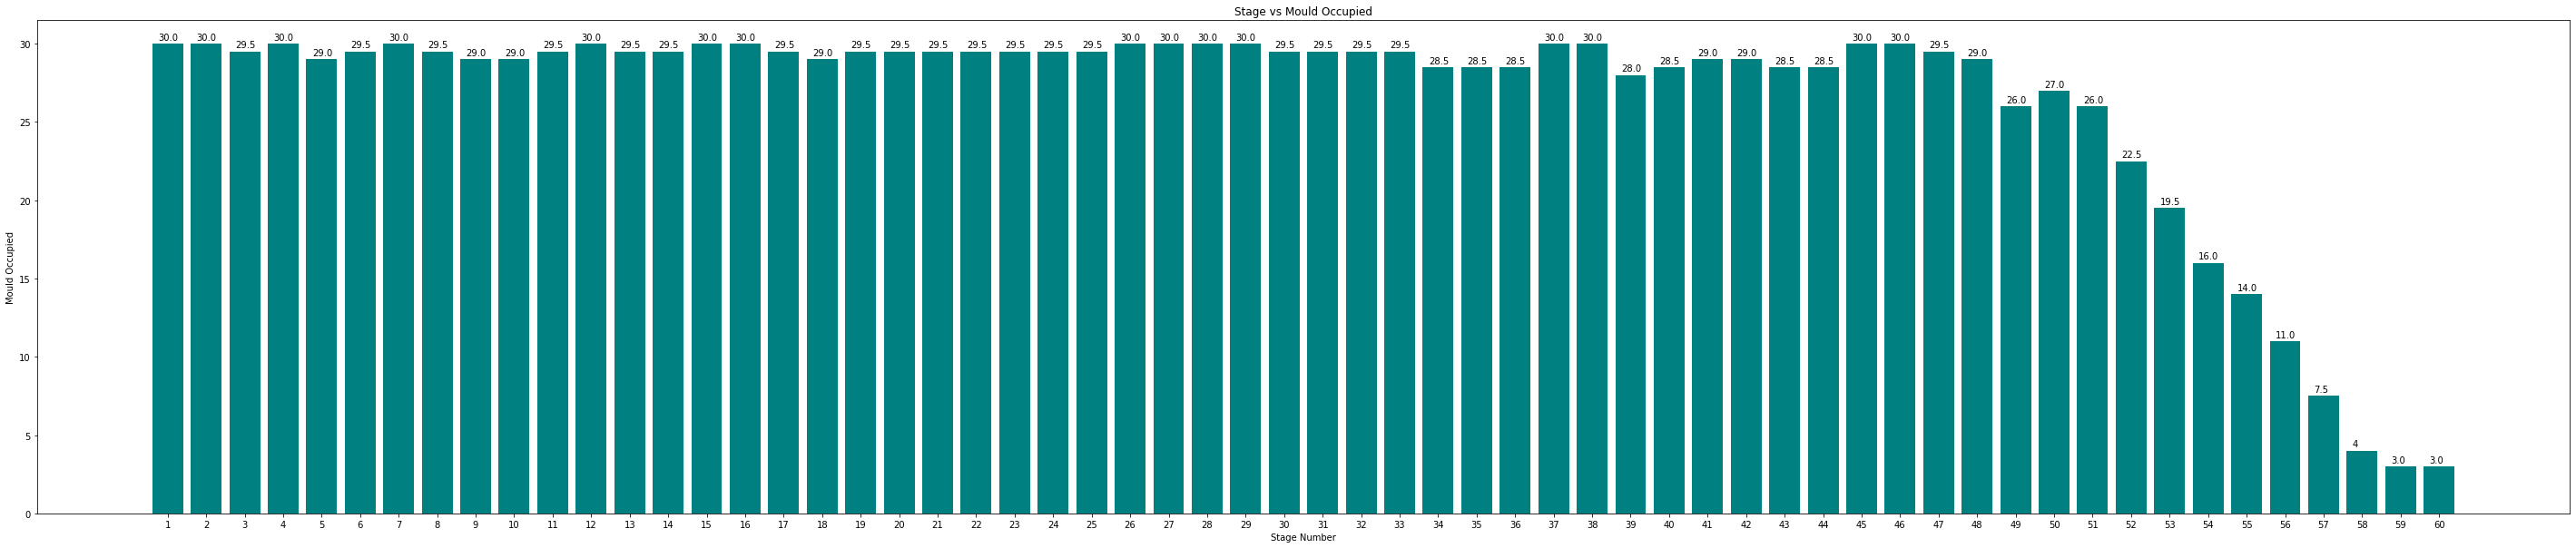

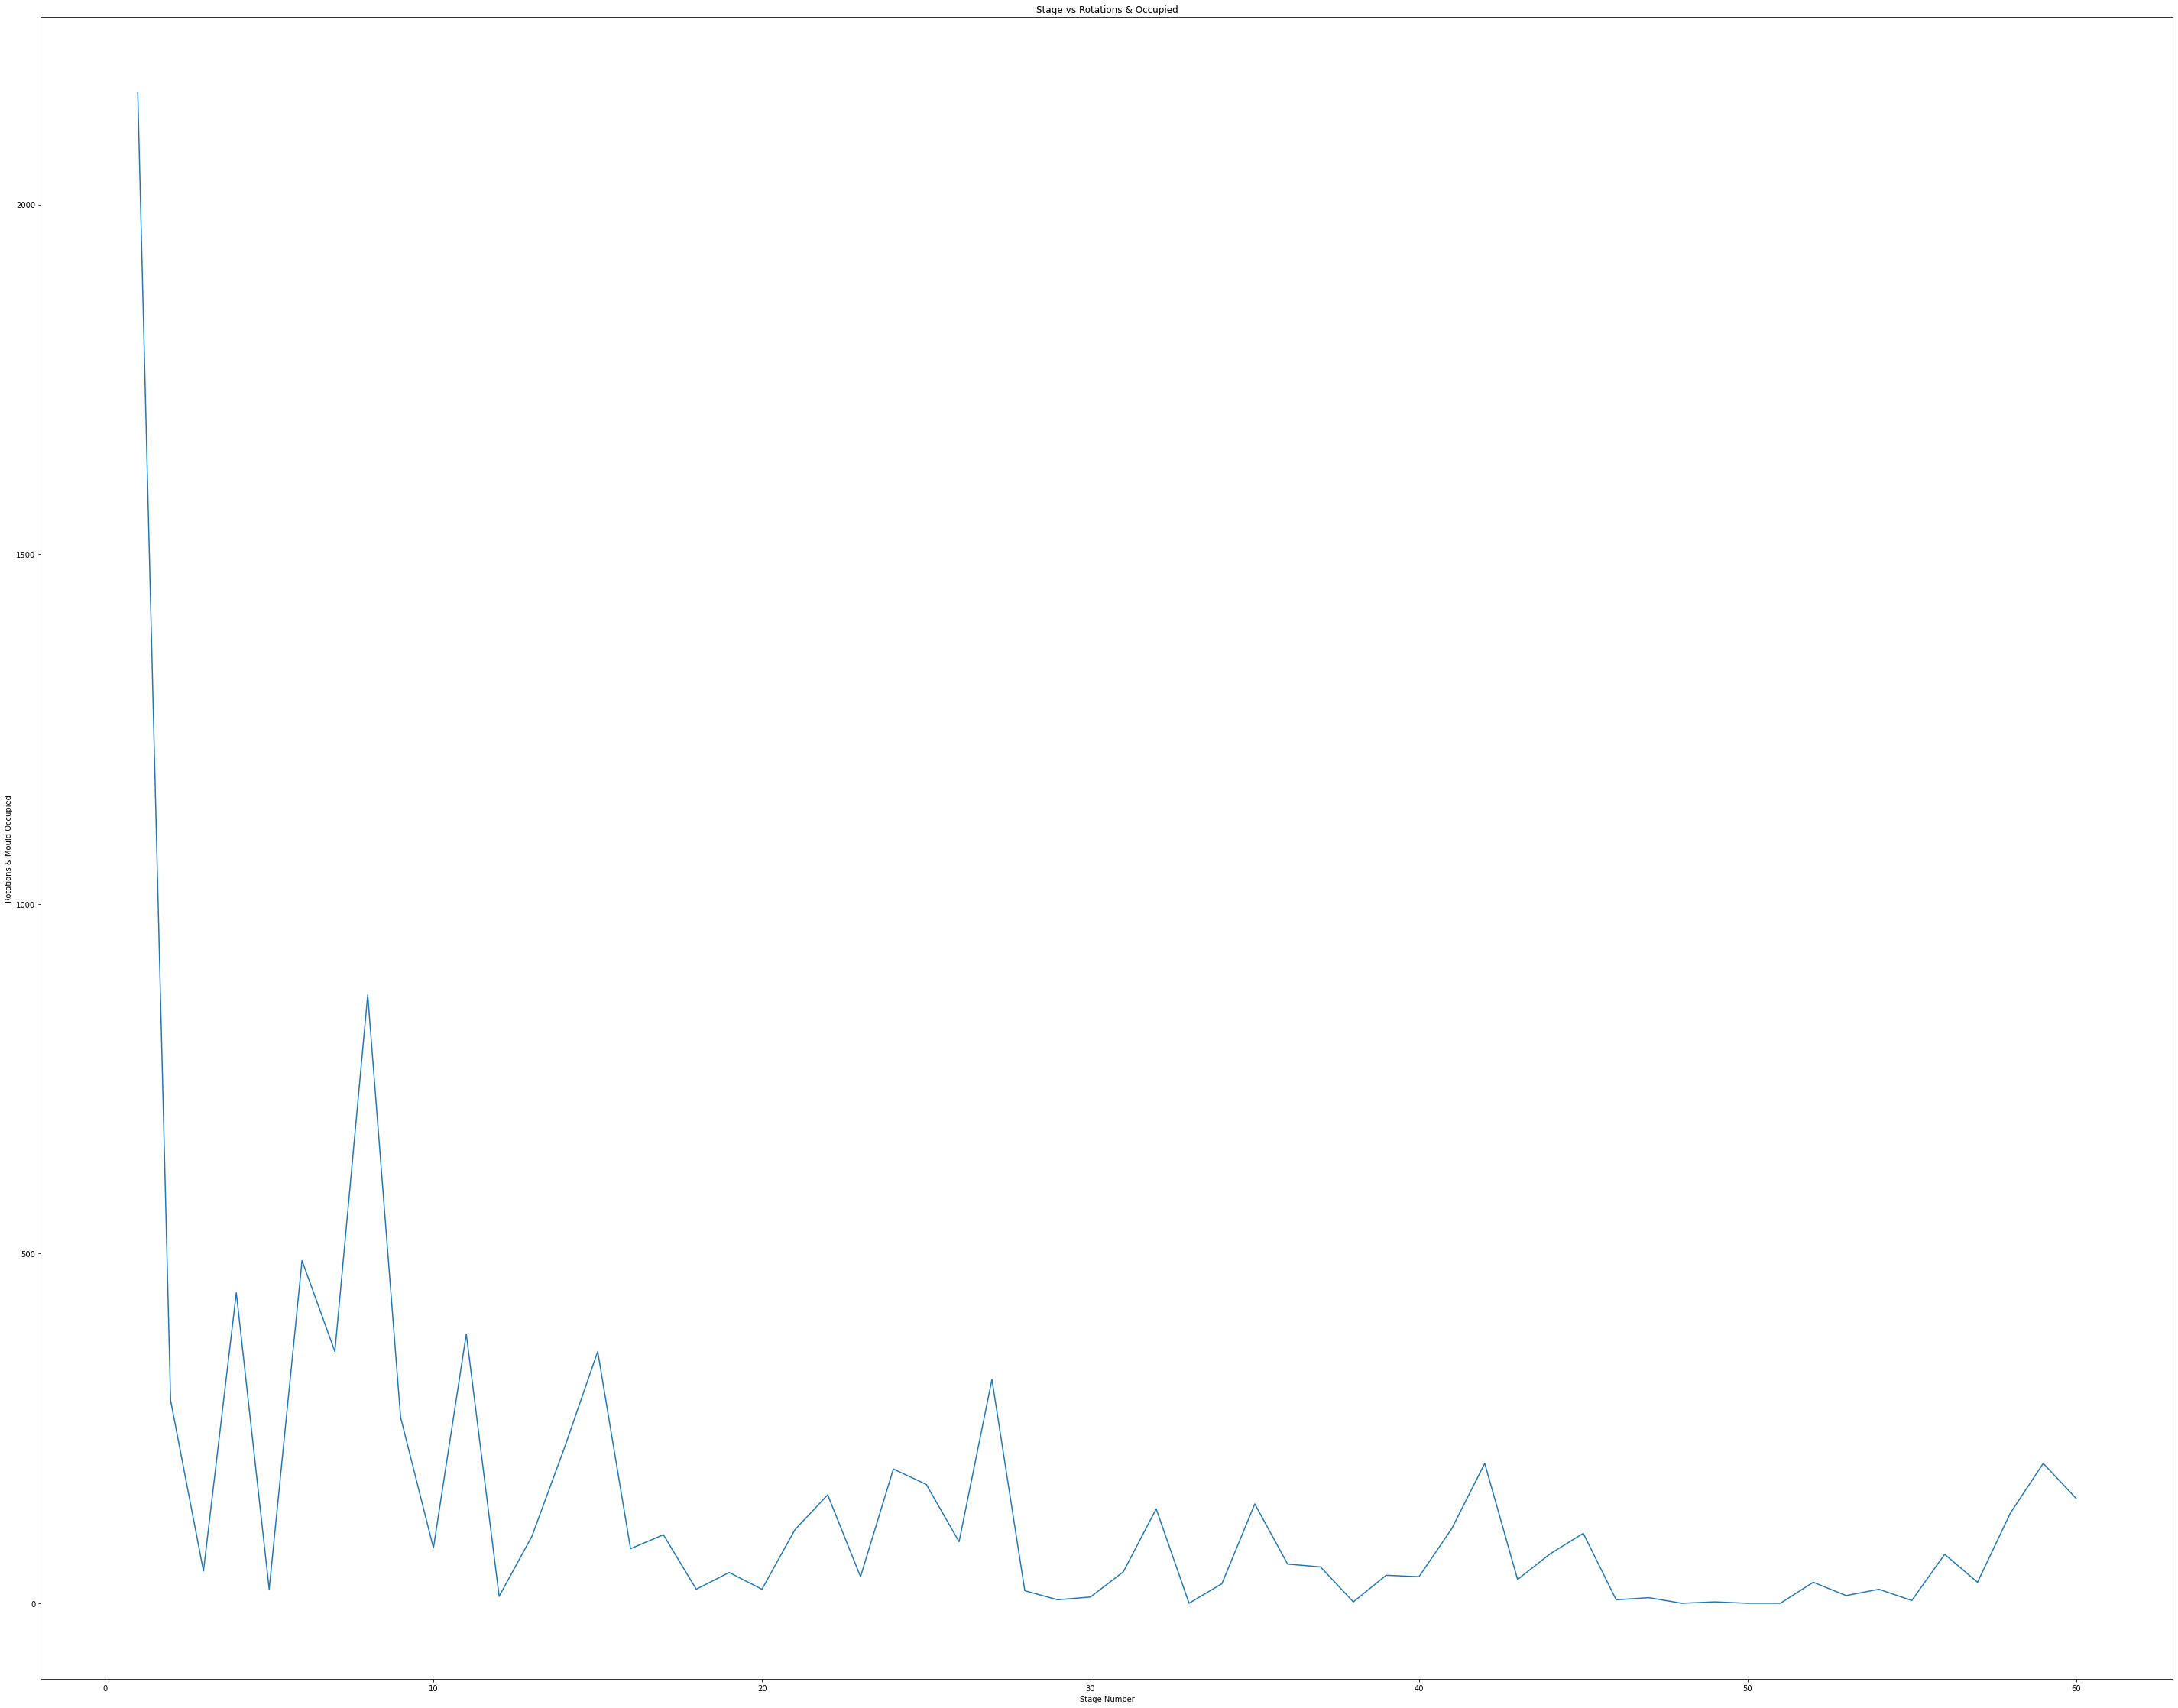

In [47]:
# plt.figure(figsize=(50,10))
fig1, ax1 = plt.subplots(figsize=(50,10))
fig2, ax2 = plt.subplots(figsize=(50,40))
ax1.bar(stage_nos, mould_occu, tick_label=stage_nos, width=0.8, color=['teal'])
ax2.plot(stage_nos, s_rotations)
# ax2.plot(stage_nos, mould_occu)
ax1.set_title("Stage vs Mould Occupied")
ax1.set_xlabel("Stage Number")
ax1.set_ylabel("Mould Occupied")
ax2.set_title("Stage vs Rotations & Occupied")
ax2.set_xlabel("Stage Number")
ax2.set_ylabel("Rotations & Mould Occupied")
for i, v in enumerate(mould_occu):
    ax1.text(stage_nos[i]-.25, mould_occu[i]+.25, str(mould_occu[i]))
    # ax2.text(stage_nos[i]-.25, mould_occu[i]+.25, str(mould_occu[i]))
plt.show()